# Report 3

This is the report for the LeNet-5 Network I implemented. I did the same preprocesing steps I mentioned in Report 1, as well as another one: the random transformation of images. Since some classes were still very underrepresented after doing the preprocessing steps I mentioned, I also did another step: The random transformation of an image into a fairly similar image. The image retains it recognaizability, but is different to the original.

Here an example:

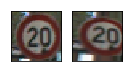

In [1]:
%matplotlib inline

import cv2
import random
import numpy as np
from skimage.transform import rotate, warp, ProjectiveTransform
import matplotlib.pyplot as plt

#prepare parameters for randomization
image_path = ('../images/train/00hc.ppm')
intensity = 0.75
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = cv2.resize(img, (32, 32), interpolation=cv2.INTER_CUBIC)
image_shape = resize.shape
image_size = image_shape[0]
d = image_size * 0.3 * intensity
#With these 8 parameters we can perform a transofrmation of the image in such a way
#that the image is different enough from the original but not too different, since
#we should be able to still recognize the class in the transformed image.
tl_top = random.uniform(-d, d)     # Top left corner, top margin
tl_left = random.uniform(-d, d)    # Top left corner, left margin
bl_bottom = random.uniform(-d, d)  # Bottom left corner, bottom margin
bl_left = random.uniform(-d, d)    # Bottom left corner, left margin
tr_top = random.uniform(-d, d)     # Top right corner, top margin
tr_right = random.uniform(-d, d)   # Top right corner, right margin
br_bottom = random.uniform(-d, d)  # Bottom right corner, bottom margin
br_right = random.uniform(-d, d)   # Bottom right corner, right margin
transform = ProjectiveTransform()
transform.estimate(np.array((
           (tl_left, tl_top),
           (bl_left, image_size - bl_bottom),
           (image_size - br_right, image_size - br_bottom),
           (image_size - tr_right, tr_top)
       )), np.array((
           (0, 0),
           (0, image_size),
           (image_size, image_size),
           (image_size, 0)
       )))
warped = warp(resize,
           transform, output_shape=(image_size, image_size), order = 1, mode = 'edge')
fig = plt.figure(figsize=(2, 1))
axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
axis.imshow(resize)
axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
axis.imshow(warped)
plt.show()

As you can see, in the left is the original and in the right the transformed image. The image mantains its properties (i.e. we can easily recognize its the same class) but is different. 

Now lets see how my implementation of LeNet fares against this:

In [2]:
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def tanh_lecun(x):
    """
    The special hyperbolic tangent function proposed by LeCun.
    Built with Tensorflow primitives so that tensorflow can use it easily and propagate
    and compute the gradients appropiately.
    The function is f(a) = A*tanh(S*a), with S and A specified below.
    """
    A = tf.constant(1.17159)
    S = tf.constant(2.0/3.0)
    mult = tf.multiply(S, x)
    app = tf.nn.tanh(mult)
    return tf.multiply(A, app)

def lenet(x):
    #Parameters for randomly initliasing the different weight values.
    mu = 0
    sigma = 0.1
    #I'm gonna initialize all weights with mean 0 and 0.1 standard deviation.
    #The weight initliazition procedure proposed in LeCun gives extremely high values and
    #the network becomes inefficient. Maybe it is a good intilization for the digit recognition
    #problem but not for this problem?
    #This is the first convolutional layer C1
    #Initialize weights for the first convolutional layer. 6 feature maps connected to
    #one (1) 5x5 neighborhood in the input. 5*5*1*6=150 trainable parameters
    C1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6], mean=mu, stddev=sigma))
    #Bias for each feature map. 6 parameters, with the weights we have 156 parameters
    C1_b = tf.Variable(tf.zeros(6))
    #Define the convolution layer with the weights and biases defined.
    C1 = tf.nn.conv2d(x, C1_w, strides = [1,1,1,1], padding = 'VALID') + C1_b
    #LeCun uses a sigmoidal activation function here.
    C1 = tanh_lecun(C1)

    #This is the sub-sampling layer S2
    #Subsampling (also known as average pooling) with 2x2 receptive fields. 12 parameters.
    S2 = tf.nn.avg_pool(C1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    #The result is passed to a sigmoidal function
    S2 = tanh_lecun(S2)

    #Another convolutional layer C3.
    #Initlialize weights. 16 feature maps connected connected to 5*5 neighborhoods
    #5*5*6*16=2400+16=2416 trainable parameters. Little difference with LeCun here as they
    #have less parameters to train in this part.
    C3_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean=mu, stddev=sigma))
    #not all feature maps are used, need to split
    C3_b = tf.Variable(tf.zeros(16))
    C3 = tf.nn.conv2d(S2, C3_w, strides = [1,1,1,1], padding = 'VALID') + C3_b
    C3 = tanh_lecun(C3)

    #Sub-sampling layer S2
    S4 = tf.nn.avg_pool(C3, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    #Activation
    S4 = tanh_lecun(S4)

    #C5: Flattened with 120 feature maps. Full connection. Labeled as convolutional
    #insted of fully-connected because if LeNet-5 input were made bigger with
    #everything else kept constat the feature map dimension would be larger than 1x1.
    #Shape = 400 since each unit is connected to 5x5 neighbors on the 16 features maps
    #of S4.
    C5 = flatten(S4)
    C5_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean=mu, stddev=sigma))
    C5_b = tf.Variable(tf.zeros(120))
    C5 = tf.matmul(C5,C5_w) + C5_b
    #Activation
    C5 = tanh_lecun(C5)

    #Fully connected with 84 units. Has 10164 trainable parameters 120*84 + 84 = 10164
    F6_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean=mu, stddev=sigma))
    F6_b = tf.Variable(tf.zeros(84))
    F6 = tf.matmul(C5,F6_w) + F6_b
    # Activation
    F6 = tanh_lecun(F6)

    # Output Layer: shape 84x43 (84 from the last layer, 43 because that is the number of
    # classes in our classification problem).
    out_w = tf.Variable(tf.truncated_normal(shape = (84,43), mean=mu, stddev=sigma))
    out_b = tf.Variable(tf.zeros(43))
    out = tf.matmul(F6, out_w) + out_b
    return out

def create_input(path):
    """
    Create Lenet's input with appropiate structure given a path (e.g. './images/train' or
    './images/test')
    """
    folder =  path
    files = os.listdir(folder)
    x = []
    y = []
    image_paths = []
    scaler = MinMaxScaler(feature_range=(-0.1, 1.175))
    #noramlized as in LeCun, makes the mean input roughly 0 and the variance roughly 1.
    #This accelerates learning.
    for i, images in sorted(enumerate(files)):
        label = images[0:2] #class identifier is in these positions
        image_path = folder + '/' + images
        image_paths.append(image_path)
        image_read = cv2.imread(image_path, 0)
        resize = cv2.resize(image_read, (32, 32), interpolation=cv2.INTER_CUBIC)
        X_new = scaler.fit_transform(resize)
        x.append(X_new)
        y.append(int(label))
    X = np.array(x)
    n, m, p = X.shape
    x_aux = []
    for example in X:
        for row in example:
            for element in row:
                x_aux.append([element])
    x_aux = np.array(x_aux)
    x_aux = np.reshape(x_aux, (n, 32, 32, 1))
    return x_aux, y, image_paths

d = '../images/test'
X_test, y_test, _ = create_input(d)
BATCH_SIZE = 1
#auxiliary
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43) #Diagonal 43x43 Identity Matrix
#Initialize
out = lenet(x)

#see if the prediction is correct, create an accuracy operation
correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data, batch_size):
    """
    Evaluate how well the models does on the training set.
    """
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size],y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples, total_accuracy

with tf.Session() as sess:
    #Initialize
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    #Restore saved model
    saver.restore(sess, tf.train.latest_checkpoint('../models/model3/saved/'))

    #Evaluate
    test_accuracy, total_accuracy = evaluate(X_test, y_test, BATCH_SIZE)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

/home/meyer/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


INFO:tensorflow:Restoring parameters from ../models/model3/saved/lenet
Test Accuracy = 0.840


As you can see, we have an accuracy of 84%. That is pretty good for a database with such few images! Deep neural networks are so much better at classifying than linear models.